In [1]:
"""
September 2020 by Oliver Gurney-Champion & Misha Kaandorp
oliver.gurney.champion@gmail.com / o.j.gurney-champion@amsterdamumc.nl
https://www.github.com/ochampion

Code is uploaded as part of our publication in MRM (Kaandorp et al. Improved unsupervised physics-informed deep learning for intravoxel-incoherent motion modeling and evaluation in pancreatic cancer patients. MRM 2021)

requirements:
numpy
torch
tqdm
matplotlib
scipy
joblib
"""

# this loads all patient data and evaluates it all.
import os
import time
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('./sw')

import IVIMNET.deep as deep
import torch
from IVIMNET.fitting_algorithms import fit_dats
from IVIMNET.hyperparams import hyperparams as hp

arg = hp()
arg = deep.checkarg(arg)

testdata = False

./sw/IVIMNET/deep.py:882: UserWarning: arg no norm_data_full. Using default of False
  warnings.warn('arg no norm_data_full. Using default of False')
./sw/IVIMNET/deep.py:789: UserWarning: arg.train.plateau_size not defined. Using default of 20
  warnings.warn('arg.train.plateau_size not defined. Using default of 20')


In [2]:
### folder patient data
folder = './sw/data/example_data'

### load patient data
print('Load patient data \n')
# load and init b-values
text_file = np.genfromtxt('{folder}/bvalues.bval'.format(folder=folder))
bvalues = np.array(text_file)
selsb = np.array(bvalues) == 0
# load nifti
data = nib.load('{folder}/data.nii.gz'.format(folder=folder))
datas = data.get_fdata() 
# reshape image for fitting
sx, sy, sz, n_b_values = datas.shape 
X_dw = np.reshape(datas, (sx * sy * sz, n_b_values))

### select only relevant values, delete background and noise, and normalise data
S0 = np.nanmean(X_dw[:, selsb], axis=1)
S0[S0 != S0] = 0
S0 = np.squeeze(S0)
valid_id = (S0 > (0.5 * np.median(S0[S0 > 0]))) 
datatot = X_dw[valid_id, :]
# normalise data
S0 = np.nanmean(datatot[:, selsb], axis=1).astype('<f')
datatot = datatot / S0[:, None]
print('Patient data loaded\n')

Load patient data 

Patient data loaded



In [3]:
### least square fitting
if arg.fit.do_fit:
    print(f'Conventional fitting on {arg.fit.jobs} cores\n')
    start_time = time.time()
    paramslsq = fit_dats(bvalues.copy(), datatot.copy()[:, :len(bvalues)], arg.fit)
    elapsed_time1 = time.time() - start_time
    print('\ntime elapsed for lsqfit: {}\n'.format(elapsed_time1))
    # define names IVIM params
    names_lsq = ['D_{}_{}'.format(arg.fit.method, 'fitS0' if not arg.fit.fitS0 else 'freeS0'),
                 'f_{}_{}'.format(arg.fit.method, 'fitS0' if not arg.fit.fitS0 else 'freeS0'),
                 'Dp_{}_{}'.format(arg.fit.method, 'fitS0' if not arg.fit.fitS0 else 'freeS0')]
    
    tot = 0
    # fill image array
    for k in range(len(names_lsq)):
        img = np.zeros([sx * sy * sz])
        img[valid_id] = paramslsq[k][tot:(tot + sum(valid_id))]
        img = np.reshape(img, [sx, sy, sz])
        nib.save(nib.Nifti1Image(img, data.affine, data.header),'{folder}/{name}.nii.gz'.format(folder=folder,name=names_lsq[k]))
    print('Conventional fitting done\n')

Conventional fitting on 12 cores

running conventional fit



100%|██████████| 110589/110589 [01:55<00:00, 961.53it/s] 



time elapsed for lsqfit: 116.23699021339417

Conventional fitting done



In [4]:
print('NN fitting\n')
res = [i for i, val in enumerate(datatot != datatot) if not val.any()] # Remove NaN data
start_time = time.time()
# train network
net = deep.learn_IVIM(datatot[res], bvalues, arg)
elapsed_time1net = time.time() - start_time
print('\ntime elapsed for Net: {}\n'.format(elapsed_time1net))
start_time = time.time()

NN fitting

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


501it [00:10, 45.72it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 26.32it/s]



Loss: 0.06987163852900266, validation_loss: 0.03643806651234627, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


501it [00:10, 46.60it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 29.98it/s]



Loss: 0.03004070498049259, validation_loss: 0.024118755012750626, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


501it [00:10, 47.62it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 24.27it/s]



Loss: 0.023374198839068414, validation_loss: 0.020435014739632607, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


501it [00:10, 47.69it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 35.78it/s]



Loss: 0.020578730177134276, validation_loss: 0.018508903682231903, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


501it [00:11, 45.46it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 31.13it/s]



Loss: 0.01912904100678861, validation_loss: 0.017850035801529884, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


501it [00:10, 49.47it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 33.95it/s]



Loss: 0.01830565341003239, validation_loss: 0.017369266599416733, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


501it [00:10, 48.19it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 28.13it/s]



Loss: 0.017834551794454454, validation_loss: 0.01728024333715439, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


501it [00:10, 49.11it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 30.78it/s]



Loss: 0.017501590641215443, validation_loss: 0.016817545518279076, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


501it [00:10, 48.29it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 33.15it/s]



Loss: 0.01728604298271239, validation_loss: 0.016420328989624977, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


501it [00:10, 47.54it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 32.13it/s]



Loss: 0.017133924435824156, validation_loss: 0.016318755224347115, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


501it [00:10, 46.79it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 23.98it/s]



Loss: 0.016977159205824138, validation_loss: 0.016238827258348465, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


501it [00:11, 44.99it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 29.09it/s]



Loss: 0.01683399333432317, validation_loss: 0.016128256916999817, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


501it [00:10, 49.11it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 26.98it/s]



Loss: 0.016736196191981436, validation_loss: 0.01614292338490486, lr: 3e-05
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


501it [00:09, 51.23it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 32.78it/s]



Loss: 0.016656109226867558, validation_loss: 0.016054097563028336, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


501it [00:10, 47.12it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 29.62it/s]



Loss: 0.016640414871275426, validation_loss: 0.016033073887228966, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


501it [00:10, 47.81it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 33.85it/s]



Loss: 0.016590999403968455, validation_loss: 0.016055461019277573, lr: 3e-05
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


501it [00:10, 48.25it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 32.43it/s]



Loss: 0.016590285057201982, validation_loss: 0.016001848503947258, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


501it [00:10, 48.06it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 30.99it/s]



Loss: 0.016508911464363337, validation_loss: 0.0159902386367321, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


501it [00:10, 48.25it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 35.48it/s]



Loss: 0.01645439711213112, validation_loss: 0.01596883311867714, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


501it [00:10, 47.19it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 32.56it/s]



Loss: 0.016439698819071053, validation_loss: 0.015979208052158356, lr: 3e-05
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


501it [00:10, 49.64it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 36.05it/s]



Loss: 0.01643006284534931, validation_loss: 0.01592583768069744, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


501it [00:10, 47.29it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 33.08it/s]



Loss: 0.016424535881727934, validation_loss: 0.01592945121228695, lr: 3e-05
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


501it [00:10, 49.96it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 34.23it/s]



Loss: 0.016383321434259416, validation_loss: 0.015916738659143448, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


501it [00:10, 49.82it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 34.60it/s]



Loss: 0.01636328285560012, validation_loss: 0.01592247001826763, lr: 3e-05
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


501it [00:10, 49.59it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 33.03it/s]



Loss: 0.016270331049337984, validation_loss: 0.015888910740613937, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


501it [00:10, 48.10it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 26.89it/s]



Loss: 0.016337608670815826, validation_loss: 0.015881698578596115, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


501it [00:10, 46.36it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 30.43it/s]



Loss: 0.016325743021443486, validation_loss: 0.015907878056168556, lr: 3e-05
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


501it [00:09, 50.10it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 31.35it/s]



Loss: 0.016281121611595152, validation_loss: 0.015905365347862244, lr: 3e-05
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 2


501it [00:10, 46.43it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 30.94it/s]



Loss: 0.01631449254974723, validation_loss: 0.01587296836078167, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


501it [00:10, 47.52it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 31.59it/s]



Loss: 0.016273988012224436, validation_loss: 0.015910016372799873, lr: 3e-05
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


501it [00:10, 48.66it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 31.96it/s]



Loss: 0.01627956148609519, validation_loss: 0.015864785760641098, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


501it [00:10, 49.00it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 31.83it/s]



Loss: 0.016281114157289268, validation_loss: 0.015842974185943604, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


501it [00:10, 49.14it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



Loss: 0.01627657447569072, validation_loss: 0.01586749777197838, lr: 3e-05
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 1


501it [00:10, 48.61it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 34.35it/s]



Loss: 0.016264562781900166, validation_loss: 0.015839243307709694, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


501it [00:10, 47.44it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 30.96it/s]



Loss: 0.01626675510406494, validation_loss: 0.015863332897424698, lr: 3e-05
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


501it [00:10, 48.42it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 34.23it/s]



Loss: 0.016254374319687487, validation_loss: 0.01581708714365959, lr: 3e-05

############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


501it [00:10, 48.50it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 32.32it/s]



Loss: 0.016219898445531726, validation_loss: 0.0158213023096323, lr: 3e-05
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


501it [00:10, 50.01it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 33.09it/s]



Loss: 0.016221904257312417, validation_loss: 0.015822984278202057, lr: 3e-05
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 2


501it [00:09, 51.63it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 32.73it/s]



Loss: 0.01620009683445096, validation_loss: 0.015829769894480705, lr: 3e-05
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 3


501it [00:10, 49.29it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 34.69it/s]



Loss: 0.016236097821965813, validation_loss: 0.015953458845615387, lr: 3e-05
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 4


501it [00:10, 48.62it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 34.44it/s]



Loss: 0.016234821386635304, validation_loss: 0.015841102227568626, lr: 3e-05
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 5


501it [00:09, 50.66it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 33.96it/s]



Loss: 0.016192699510604144, validation_loss: 0.01594827137887478, lr: 3e-05
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 6


501it [00:10, 48.08it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 34.06it/s]



Loss: 0.016205319041386248, validation_loss: 0.01583491452038288, lr: 3e-05
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 7


501it [00:10, 48.16it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 26.14it/s]



Loss: 0.01622049290686846, validation_loss: 0.015892749652266502, lr: 3e-05
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 8


501it [00:10, 49.72it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 32.96it/s]



Loss: 0.016229981921613217, validation_loss: 0.0158370528370142, lr: 3e-05
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 9


501it [00:09, 51.58it/s]                           



 validation 



100%|██████████| 1/1 [00:00<00:00, 34.17it/s]


Loss: 0.01619096708483994, validation_loss: 0.015844333916902542, lr: 3e-05

Done, best val loss: 0.01581708714365959
Done

time elapsed for Net: 482.48273849487305



In [15]:
# predict parameters
%timeit paramsNN = deep.predict_IVIM(datatot, bvalues, net, arg)
elapsed_time1netinf = time.time() - start_time
print('\ntime elapsed for Net inf: {}\n'.format(elapsed_time1netinf))
print('\ndata length: {}\n'.format(len(datatot)))
if arg.train_pars.use_cuda:
    torch.cuda.empty_cache()

100%|██████████| 54/54 [00:00<00:00, 100.25it/s]

1.28 s ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

time elapsed for Net inf: 842.7111985683441


data length: 110589



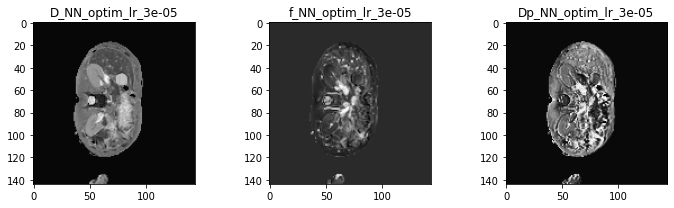

NN fitting done



In [13]:
# define names IVIM params
names = ['D_NN_{nn}_lr_{lr}'.format(nn=arg.save_name, lr=arg.train_pars.lr),
         'f_NN_{nn}_lr_{lr}'.format(nn=arg.save_name, lr=arg.train_pars.lr),
         'Dp_NN_{nn}_lr_{lr}'.format(nn=arg.save_name, lr=arg.train_pars.lr),]
tot = 0
fig, ax = plt.subplots(1,3, figsize=(10,3))
# fill image array and make nifti
for k in range(len(names)):
    img = np.zeros([sx * sy * sz])
    img[valid_id] = paramsNN[k][tot:(tot + sum(valid_id))]
    img = np.reshape(img, [sx, sy, sz])
    ax[k].imshow(img[:,:,7], cmap="gray")
    ax[k].set_title(names[k])
    # nib.save(nib.Nifti1Image(img, data.affine, data.header),'{folder}/{name}.nii.gz'.format(folder = folder,name=names[k])),
plt.tight_layout()
plt.show()
print('NN fitting done\n')

In [16]:
f"{1.28 / len(datatot):e}", f"{0.028 / len(datatot):e}"

('1.157439e-05', '2.531897e-07')